> A basic introduction to raster zonal stats 

[![](https://colab.research.google.com/assets/colab-badge.svg "Open in Colab button")](https://colab.research.google.com/github/thinkingmachines/geowrangler/blob/master/notebooks/tutorial.raster_zonal_stats.ipynb)

In [ ]:
#| include: false
# all_slow

In [ ]:
#| include: false
#| no_test
! [ -e /content ] && pip install -Uqq geowrangler

In [ ]:
#| include: false
#| no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [ ]:
#| include: false
#| no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Basic Usage

Generate zonal stats for a GeoDataframe containing areas of interest using raster data

Terms:

* **aoi** - (area of interest) a geodataframe which we are interested in generating zonal statistics for
* **raster data** - the source raster containing the features which we are interested in collecting zonal stats for our aoi.


In [ ]:
#| include: false
#| no_test
!mkdir -p ../data
# download sample geojson files from repo
![ ! -e ../data/region34ncr_admin.geojson ] && curl -s -o ../data/region34ncr_admin.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/region34ncr_admin.geojson
![ ! -e ../data/region3_admin_grids.geojson ] && curl -s -o ../data/region3_admin_grids.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/region3_admin_grids.geojson
![ ! -e ../data/region3_bingtile_grid13.geojson ] && curl -s -o ../data/region3_bingtile_grid13.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/region3_bingtile_grid13.geojson

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import geowrangler.raster_zonal_stats as rzs
import numpy as np

### Load AOI

Our areas of interest (AOI)  are three (3)  Level 1 administration regions (ADM1) of the Philippines located in the island of Luzon.

In [ ]:
%%time
# area multipolygons for regions 3,4,ncr of the philippines
aoi = gpd.read_file("../data/region34ncr_admin.geojson")

CPU times: user 1.42 s, sys: 118 ms, total: 1.54 s
Wall time: 1.57 s


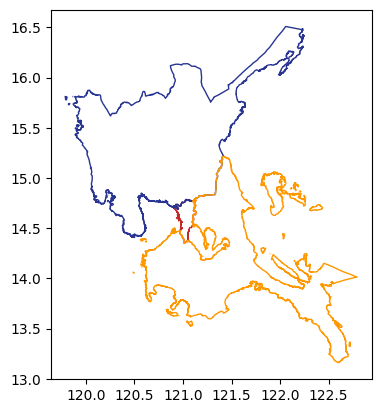

In [ ]:
#| no_test
ax = aoi.plot(
    ax=plt.axes(),
    facecolor="none",
    edgecolor=[
        "#C62828",
        "#283593",
        "#FF9800",
    ],
)

In [ ]:
#| no_test
aoi

,Reg_Code,Reg_Name,Reg_Alt_Name,geometry
0,130000000,National Capital Region,NCR,"MULTIPOLYGON (((121.03842 14.78525, 121.03815 ..."
1,030000000,Region III,Central Luzon,"MULTIPOLYGON (((120.11687 14.76309, 120.11684 ..."
2,040000000,Region IV-A,Calabarzon,"MULTIPOLYGON (((122.72165 13.36485, 122.72143 ..."


### Download Philippine Population Data
> see the [Humanitarian Data Exchange World Population Counts - Philippines](https://data.humdata.org/dataset/worldpop-population-counts-for-philippines)

We download our raster Data as GeoTiff files from the Humanitarian Data Exchange site.

:::{.callout-note}

This maybe slow as the file is about 180 Mb and depending on your internet download speed may take more than 5 minutes.

:::

In [ ]:
# PHL population HDX links
phil_pop_link = "https://data.worldpop.org/GIS/Population/Global_2000_2020/2020/PHL/phl_ppp_2020.tif"
phil_pop_dset = "phl_pop_2020.tif"

In [ ]:
%%time

![ ! -e ../data/{phil_pop_dset} ] && curl -o ../data/{phil_pop_dset} {phil_pop_link}

CPU times: user 988 µs, sys: 3.26 ms, total: 4.25 ms
Wall time: 287 ms


To create our raster zonal stats, we just need to 
set the aggregations, as well as some extra arguments,
such as the `nodata` value in the raster.

In [ ]:
%%time
results = rzs.create_raster_zonal_stats(
    aoi,
    f"../data/{phil_pop_dset}",
    aggregation=dict(
        func=["sum", "count"],
        column="population",
        output=["population_count", "samples"],
    ),
    extra_args=dict(nodata=-99999),  # nodata value is -99999
)

CPU times: user 6.15 s, sys: 195 ms, total: 6.34 s
Wall time: 6.49 s


In [ ]:
results

,Reg_Code,Reg_Name,Reg_Alt_Name,geometry,samples,population_count
0,130000000,National Capital Region,NCR,"MULTIPOLYGON (((121.03842 14.78525, 121.03815 ...",70786,13165866.0
1,030000000,Region III,Central Luzon,"MULTIPOLYGON (((120.11687 14.76309, 120.11684 ...",2558377,11493727.0
2,040000000,Region IV-A,Calabarzon,"MULTIPOLYGON (((122.72165 13.36485, 122.72143 ...",1876244,15952383.0


### Using Grid Tile AOIs

We can also use tile grids as our AOIs.


In [ ]:
# note that you don't need to load the aoi first
grid_aoi_file = "../data/region3_admin_grids.geojson"

In [ ]:
%%time
grid_aoi_results = rzs.create_raster_zonal_stats(
    grid_aoi_file,
    f"../data/{phil_pop_dset}",
    aggregation=dict(
        func=["sum", "count"],
        column="population",
        output=["population_count", "samples"],
        fillna=[True, True],
    ),
    extra_args=dict(nodata=-99999),  # nodata value is -99999
)

CPU times: user 5.15 s, sys: 657 ms, total: 5.81 s
Wall time: 5.97 s


In [ ]:
grid_aoi_results.head()

,x,y,geometry,samples,population_count
0,0,30,"POLYGON ((119.78583 15.7087, 119.83075 15.7087...",171,1171.764038
1,0,31,"POLYGON ((119.78583 15.75193, 119.83075 15.751...",329,278.567200
2,0,32,"POLYGON ((119.78583 15.79516, 119.83075 15.795...",345,279.140198
3,1,30,"POLYGON ((119.83075 15.7087, 119.87566 15.7087...",158,808.681152
4,1,32,"POLYGON ((119.83075 15.79516, 119.87566 15.795...",20,0.000000


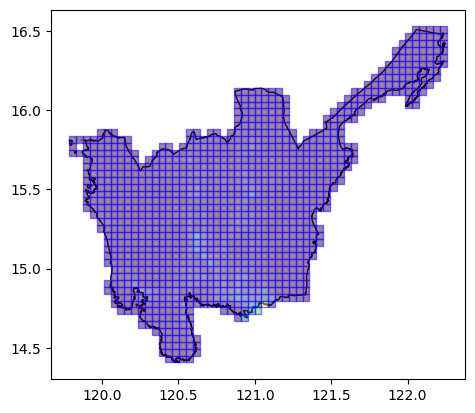

In [ ]:
#| no_test
ax = aoi[aoi.Reg_Name == "Region III"].plot(
    ax=plt.axes(), facecolor="none", edgecolor="black"
)
ax = grid_aoi_results.plot(
    ax=ax, column="population_count", edgecolor="blue", alpha=0.5
)

### Using Bing Tile Grid Tile AOIs

We can also use pre-existing Bing tile grids as our AOIs.


In [ ]:
# note that you don't need to load the aoi first
bingtile_grid_aoi_file = "../data/region3_bingtile_grid13.geojson"

In [ ]:
%%time
bingtile_grid_aoi_results = rzs.create_raster_zonal_stats(
    bingtile_grid_aoi_file,
    f"../data/{phil_pop_dset}",
    aggregation=dict(
        func=["sum", "count"],
        column="population",
        output=["population_count", "samples"],
        fillna=[True, True],
    ),
    extra_args=dict(nodata=-99999),  # nodata value is -99999
)

CPU times: user 5.17 s, sys: 486 ms, total: 5.65 s
Wall time: 5.71 s


In [ ]:
bingtile_grid_aoi_results.head()

,quadkey,geometry,samples,population_count
0,1323030303301,"POLYGON ((120.10254 14.73239, 120.10254 14.774...",737,196.756744
1,1323030303300,"POLYGON ((120.05859 14.73239, 120.05859 14.774...",50,35.732861
2,1323030303311,"POLYGON ((120.19043 14.73239, 120.19043 14.774...",248,383.338013
3,1323030303133,"POLYGON ((120.19043 14.77488, 120.19043 14.817...",901,5621.879395
4,1323030303131,"POLYGON ((120.19043 14.81737, 120.19043 14.859...",1328,6584.988770


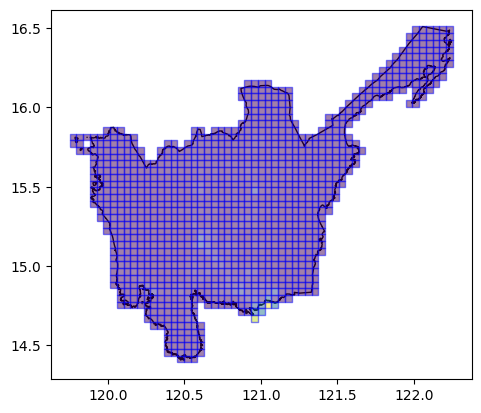

In [ ]:
#| no_test
ax = aoi[aoi.Reg_Name == "Region III"].plot(
    ax=plt.axes(), facecolor="none", edgecolor="black"
)
ax = bingtile_grid_aoi_results.plot(
    ax=ax, column="population_count", edgecolor="blue", alpha=0.5
)

## Exactextract Usage (experimental)

`raster_zonal_stats` also includes an experimental method `create_exactextract_zonal_stats()` which uses the [`exactextract`](https://github.com/isciences/exactextract) python package. This method offers the ff. advantages over the basic usage:
- Faster and more accurate statistics vs basic method
- Support for multi-band rasters
- Support for weighted statistics

:::{.callout-warning}
The exactextract method is still experimental and is subject to change in future releases. Values between the basic and exactextract method will also differ for the same input AOI and raster.
:::

### Replicate basic usage using exactextract
In this section, we demonstrate the zonal statistics performed for the same ff. aois using the `create_exactextract_zonal_stats` method.
1. Philippines ADM1 regions
2. Grid Tile AOIs
3. Bing Tile Grid Tile AOIs

:::{.callout-note}
While `create_raster_zonal_stats()` and `create_exactextract_zonal_stats()` share a similar interface, in for the latter method, it is required to specify a `band` for each entry for `aggregation`.
:::

#### ADM1 AOIs (exactextract)

In [ ]:
%%time
results = rzs.create_exactextract_zonal_stats(
    aoi,
    f"../data/{phil_pop_dset}",
    aggregation=dict(
        func=["sum", "count"],
        band=1,
        output=["population_count", "samples"],
    )
)

CPU times: user 1.74 s, sys: 135 ms, total: 1.88 s
Wall time: 1.9 s


In [ ]:
results

,Reg_Code,Reg_Name,Reg_Alt_Name,geometry,population_count,samples
0,130000000,National Capital Region,NCR,"MULTIPOLYGON (((121.03842 14.78525, 121.03815 ...",13165218.0,7.076045e+04
1,030000000,Region III,Central Luzon,"MULTIPOLYGON (((120.11687 14.76309, 120.11684 ...",11497926.0,2.558353e+06
2,040000000,Region IV-A,Calabarzon,"MULTIPOLYGON (((122.72165 13.36485, 122.72143 ...",15954625.0,1.876141e+06


#### Grid Tile AOIs (exactextract)

In [ ]:
%%time
grid_aoi_results = rzs.create_exactextract_zonal_stats(
    grid_aoi_file,
    f"../data/{phil_pop_dset}",
    aggregation=dict(
        func=["sum", "count"],
        band=1,
        output=["population_count", "samples"]
    )
)

CPU times: user 533 ms, sys: 15.7 ms, total: 549 ms
Wall time: 551 ms


In [ ]:
grid_aoi_results

,x,y,geometry,population_count,samples
0,0,30,"POLYGON ((119.78583 15.7087, 119.83075 15.7087...",1212.030518,173.795197
1,0,31,"POLYGON ((119.78583 15.75193, 119.83075 15.751...",275.465424,323.370850
2,0,32,"POLYGON ((119.78583 15.79516, 119.83075 15.795...",292.621063,355.625183
3,1,30,"POLYGON ((119.83075 15.7087, 119.87566 15.7087...",794.559692,162.660583
4,1,32,"POLYGON ((119.83075 15.79516, 119.87566 15.795...",0.000000,20.000000
...,...,...,...,...,...
1069,54,44,"POLYGON ((122.21128 16.31312, 122.2562 16.3131...",328.646301,43.474117
1070,54,45,"POLYGON ((122.21128 16.35623, 122.2562 16.3562...",2358.856445,1147.846558
1071,54,46,"POLYGON ((122.21128 16.39932, 122.2562 16.3993...",1703.188232,493.368500
1072,54,47,"POLYGON ((122.21128 16.4424, 122.2562 16.4424,...",416.854004,980.471924


#### Bing Tile Grid Tile AOIs (exactextract)

In [ ]:
%%time
bingtile_grid_aoi_results = rzs.create_exactextract_zonal_stats(
    bingtile_grid_aoi_file,
    f"../data/{phil_pop_dset}",
    aggregation=dict(
        func=["sum", "count"],
        band=1,
        output=["population_count", "samples"]
    )
)

CPU times: user 554 ms, sys: 16.4 ms, total: 570 ms
Wall time: 581 ms


In [ ]:
bingtile_grid_aoi_results

,quadkey,geometry,population_count,samples
0,1323030303301,"POLYGON ((120.10254 14.73239, 120.10254 14.774...",201.693375,756.642822
1,1323030303300,"POLYGON ((120.05859 14.73239, 120.05859 14.774...",33.127304,44.116634
2,1323030303311,"POLYGON ((120.19043 14.73239, 120.19043 14.774...",388.166870,253.282425
3,1323030303133,"POLYGON ((120.19043 14.77488, 120.19043 14.817...",5789.487793,904.081543
4,1323030303131,"POLYGON ((120.19043 14.81737, 120.19043 14.859...",6430.809570,1322.331665
...,...,...,...,...
1119,1323030120123,"POLYGON ((119.75098 15.79225, 119.75098 15.834...",155.952072,227.437897
1120,1323030120301,"POLYGON ((119.75098 15.74996, 119.75098 15.792...",109.296829,128.834396
1121,1323030120132,"POLYGON ((119.79492 15.79225, 119.79492 15.834...",177.168594,193.092102
1122,1323030120310,"POLYGON ((119.79492 15.74996, 119.79492 15.792...",136.064529,134.635620


### Multi-band Usage
`create_exactextract_zonal_stats()` supports multi-band statistics calculations by specifying a different `aggregation` per band.

For this demo, we use Sentinel-5P aerosol absorbing index, which contains 2 bands for aersols at 340nm and 380nm diameter.

In [ ]:
exactextract_multiband_results = rzs.create_exactextract_zonal_stats(
    grid_aoi_file,
    "../data/ph_s5p_AER_AI_340_380.tiff",
    aggregation=[
        dict(band=1, func=["mean", "sum"], output=["mean absorbing aerosol index (340nm)", "sample_count"]),
        dict(band=2, func=["mean", "sum"], output="aer_ai_380nm"), 
    ]
)

In [ ]:
exactextract_multiband_results.sort_values(by="sample_count", ascending=False)

,x,y,geometry,mean absorbing aerosol index (340nm),sample_count,aer_ai_380nm_mean,aer_ai_380nm_sum
34,4,25,"POLYGON ((119.9655 15.49239, 120.01041 15.4923...",0.098937,0.049710,0.753341,0.378512
33,4,24,"POLYGON ((119.9655 15.4491, 120.01041 15.4491,...",0.087453,0.043949,0.665897,0.334646
56,5,25,"POLYGON ((120.01041 15.49239, 120.05533 15.492...",0.030743,0.015447,0.242179,0.121682
55,5,24,"POLYGON ((120.01041 15.4491, 120.05533 15.4491...",0.027175,0.013657,0.239243,0.120231
20,3,25,"POLYGON ((119.92058 15.49239, 119.9655 15.4923...",0.009051,0.004548,0.068916,0.034626
...,...,...,...,...,...,...,...
367,16,30,"POLYGON ((120.50449 15.7087, 120.5494 15.7087,...",0.000000,0.000000,0.000048,0.000024
368,16,31,"POLYGON ((120.50449 15.75193, 120.5494 15.7519...",0.000000,0.000000,0.000000,0.000000
369,17,0,"POLYGON ((120.5494 14.40753, 120.59432 14.4075...",0.000000,0.000000,0.003331,0.001682
370,17,1,"POLYGON ((120.5494 14.45102, 120.59432 14.4510...",0.000000,0.000000,0.000000,0.000000


### Other options
This section demonstrates other options that you can pass to `create_exactextract_zonal_stats()`

If `include_geom=False` the result is returned without the active geometry column.

In [ ]:
%%time
no_geom_results = rzs.create_exactextract_zonal_stats(
    grid_aoi_file,
    f"../data/{phil_pop_dset}",
    aggregation=dict(
        func=["sum", "count"],
        band=1,
        output=["population_count", "samples"]
    ),
    include_geom=False
)
no_geom_results

CPU times: user 536 ms, sys: 14.8 ms, total: 551 ms
Wall time: 552 ms


,x,y,population_count,samples
0,0,30,1212.030518,173.795197
1,0,31,275.465424,323.370850
2,0,32,292.621063,355.625183
3,1,30,794.559692,162.660583
4,1,32,0.000000,20.000000
...,...,...,...,...
1069,54,44,328.646301,43.474117
1070,54,45,2358.856445,1147.846558
1071,54,46,1703.188232,493.368500
1072,54,47,416.854004,980.471924


By specifying `include_cols`, the result will return only the specified columns from the AOI in addition to the aggregation results.

In [ ]:
%%time
include_cols_results = rzs.create_exactextract_zonal_stats(
    grid_aoi_file,
    f"../data/{phil_pop_dset}",
    aggregation=dict(
        func=["sum", "count"],
        band=1,
        output=["population_count", "samples"]
    ),
    include_cols=["x"]
)
include_cols_results

CPU times: user 534 ms, sys: 15.7 ms, total: 550 ms
Wall time: 557 ms


,x,population_count,samples
0,0,1212.030518,173.795197
1,0,275.465424,323.370850
2,0,292.621063,355.625183
3,1,794.559692,162.660583
4,1,0.000000,20.000000
...,...,...,...
1069,54,328.646301,43.474117
1070,54,2358.856445,1147.846558
1071,54,1703.188232,493.368500
1072,54,416.854004,980.471924


### Comparison of `exactextract` and `rasterstats`

#### Processing time
The following section compares the mean processing time of `exactextract` vs `rasterstats` over 10 iterations of equivalent function calls.

As an example from one notebook run:
- `rasterstats`: 11.6 s ± 1.16 s -> equivalent to 11,600 ms 
- `exactextract`: 763 ms ± 46.1 ms
- Resulting speed-up: **~15x faster**

In [ ]:
%%timeit -r 10
rasterstats_results = rzs.create_raster_zonal_stats(
    grid_aoi_file,
    f"../data/{phil_pop_dset}",
    aggregation=dict(
        func=["sum", "count"],
        column="population",
        output=["population_count", "samples"]
    ),
    extra_args=dict(nodata=-99999),  # nodata value is -99999
)

5.43 s ± 73.1 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [ ]:
%%timeit -r 10
exactextract_results = rzs.create_exactextract_zonal_stats(
    grid_aoi_file,
    f"../data/{phil_pop_dset}",
    aggregation=dict(
        func=["sum", "count"],
        band=1,
        output=["population_count", "samples"]
    )
)

552 ms ± 5.91 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


#### Output value comparison
We also compare the difference in values between the two methods. Output from the two methods may differ significantly because of the way the pixels are distributed to each AOI. The difference also becomes more significant with smaller AOIs and coarser input rasters, as these factors increase the amount of pixels that are located along AOI boundaries.

In [ ]:
rasterstats_results = rzs.create_raster_zonal_stats(
    grid_aoi_file,
    f"../data/{phil_pop_dset}",
    aggregation=dict(
        func=["sum"],
        column="population",
        output=["population_count"]
    ),
    extra_args=dict(nodata=-99999),  # nodata value is -99999
)

In [ ]:
exactextract_results = rzs.create_exactextract_zonal_stats(
    grid_aoi_file,
    f"../data/{phil_pop_dset}",
    aggregation=dict(
        func=["sum"],
        band=1,
        output=["population_count"]
    )
)

In [ ]:
percent_difference = (np.abs(exactextract_results["population_count"] - rasterstats_results["population_count"])/rasterstats_results["population_count"]) * 100
print(f"Mean percent difference between exactextract and rasterstats: {np.mean(percent_difference):.2f}%")
print(f"Median percent difference: {np.nanmedian(percent_difference):.2f}%")
print(f"Max percent difference: {np.max(percent_difference):.2f}%")
print(f"Min percent difference: {np.min(percent_difference):.2f}%")

Mean percent difference between exactextract and rasterstats: 1.33%
Median percent difference: 0.80%
Max percent difference: 25.71%
Min percent difference: 0.00%


#### Recommendations
We make the following recommendations on when to use each method.

Use `create_raster_zonal_stats()` (`rasterstats`) if:
- You are working with kilometer-scale AOIs, where the processing time trade-off is acceptable
- You need to set the NODATA value during the function call
- You are working with legacy projects using older versions of `geowrangler`, and/or relying on results previously generated from `create_raster_zonal_stats()`.


Use `create_exactextract_zonal_stats()` (`exactextract`) if:
- You are working with meter-scale AOIs, such that the processing time improvement is crucial
- Your rasters are well-defined with `NODATA` properly set in the metadata. The method does not currently support setting NODATA in the function call and only relies on reading the raster metadata.
- You are working on a new project with no prior dependencies to `create_raster_zonal_stats()`.